# Running side-evaluation

This notebook contains the necessary code to run the experiment described in Appendix A of the paper, where we choose the masking strategy to use in subsequent experiments.


In [1]:
import seaborn as sns
sns.set_style("whitegrid")
import os
import json
from operator import itemgetter
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pickle
from utils import load_representations, load_similarities

mask_types = ['no-mask','one-mask','multi-mask']

In [2]:
all_reps = load_representations("bert_representations")
all_data = load_similarities("bert_representations")

In [3]:

def evaluate_masking_strategies(all_data, cluster_type="all"):
    '''cluster_type can be "all", "word" or "coref"'''    
    
    skipped_convs = []    
    accumulated_comparisons_outcome = dict()
    for mask_type in mask_types:            
        accumulated_comparisons_outcome[mask_type] = []
    
    words_included = 0
    words_per_debate = []             

    for debate_name in all_data:
        debate_sims = all_data[debate_name]
        words_this_debate = 0
        # select the clusters to use: only those for which we could calculate similarities 
        selected_clusters = [cl for cl in debate_sims if cl['similarity']]
        # if evaluating only a specific cluster type (coref or word), pick clusters of this type only
        if cluster_type != "all":
            selected_clusters = [cl for cl in selected_clusters if cl['type'] == cluster_type]
        
        if len(selected_clusters) == 0:
            print(debate_name) 
            skipped_convs.append(debate_name)        
        
        # accumulate similarities
        for mask_type in mask_types: 
            sims_by_class = {'DIFF-1':[], 'DIFF-2':[], 'SAME-for':[],'SAME-against':[]}
            sim_by_class = dict()
            for cl in selected_clusters:                
                sim_by_class['BETWEEN-1'] = cl['similarity'][mask_type]['BETWEEN']['1']['similarity']
                sim_by_class['BETWEEN-2'] = cl['similarity'][mask_type]['BETWEEN']['2']['similarity']
                sim_by_class['WITHIN-for'] = cl['similarity'][mask_type]['WITHIN']['for']['similarity']
                sim_by_class['WITHIN-against'] = cl['similarity'][mask_type]['WITHIN']['against']['similarity']    
                
                # How often do BETWEEN comparisons have a lower similarity than WITHIN comparisons?                
                accumulated_comparisons_outcome[mask_type].append(int(sim_by_class['BETWEEN-1'] < sim_by_class['WITHIN-for']))
                accumulated_comparisons_outcome[mask_type].append(int(sim_by_class['BETWEEN-1'] < sim_by_class['WITHIN-against']))
                accumulated_comparisons_outcome[mask_type].append(int(sim_by_class['BETWEEN-2'] < sim_by_class['WITHIN-for']))
                accumulated_comparisons_outcome[mask_type].append(int(sim_by_class['BETWEEN-2'] < sim_by_class['WITHIN-against']))          
                
                if mask_type == "no-mask": # mask_type is irrelevant here, we only want to collect this info once
                    words_included +=1
                    words_this_debate +=1
        
        
        words_per_debate.append(words_this_debate)
    
    # Calculating accuracy
    eval_metrics = dict()
    eval_metrics_fordf = []
    for mask_type in accumulated_comparisons_outcome:        
        value = sum(accumulated_comparisons_outcome[mask_type])/len(accumulated_comparisons_outcome[mask_type])        
        eval_metrics[mask_type] = value
        eval_metrics_fordf.append({'mask_type':mask_type, 'value': value})

    eval_metrics_df = pd.DataFrame(eval_metrics_fordf)
    print(eval_metrics_df)

    sns.barplot(data=eval_metrics_df, y="value", x="mask_type")   
    
    
    print("skipped debates:", skipped_convs)    
    print("total number of words used:", words_included)
    print("avg number of words per debate:",  np.average(words_per_debate))
    
    print("\n** TYPE OF CLUSTER: ", cluster_type, " **")
    
    return eval_metrics, eval_metrics_df

    mask_type     value
0     no-mask  0.702266
1    one-mask  0.689325
2  multi-mask  0.688922
skipped debates: []
total number of words used: 4965
avg number of words per debate: 45.97222222222222

** TYPE OF CLUSTER:  word  **


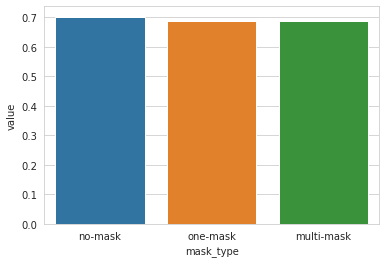

In [4]:
_, _ = evaluate_masking_strategies(all_data, cluster_type="word")

    mask_type     value
0     no-mask  0.748811
1    one-mask  0.708680
2  multi-mask  0.714328
skipped debates: []
total number of words used: 841
avg number of words per debate: 7.787037037037037

** TYPE OF CLUSTER:  coref  **


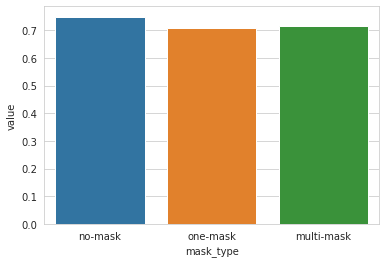

In [5]:
_, _ = evaluate_masking_strategies(all_data, cluster_type="coref")